## Imports

In [1]:
import pandas as pd
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import make_scorer, mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_union, make_pipeline
from xgboost import XGBRegressor

## Data loading

In [2]:
df = pd.read_parquet('clean_data.parquet')

## Custom transformers

In [3]:
class ExpensesImputer(BaseEstimator, TransformerMixin):
    """Imputes the expenses by using the median ratio of expenses
    against total price."""
    def fit(self, X):
        return self

    def transform(self, X):
        mask = X['expenses'].notna()
        pct = (X.loc[mask, 'expenses'] /
               (X.loc[mask, 'price'] + X.loc[mask, 'expenses'])).median()
        X.loc[~mask, 'expenses'] = (X.loc[~mask, 'price'] * pct).astype(int)
        return X

Impute expenses

In [4]:
imputer = ExpensesImputer()
df = imputer.fit_transform(df)

## Splitting features and labels

In [5]:
feature_cols = [
    'total_surface',
    'covered_surface',
    'has_balcony',
    'has_terrace',
    'has_balcony_and_terrace',
    'rooms',
    'is_studio_apartment',
    'has_garage'
]
df.loc[:, 'total_price'] = df['price'] + df['expenses']

X = df.loc[:, feature_cols]
y = df['total_price']

## Model

Pipeline

In [6]:
model = XGBRegressor()

feature_union = make_union(
    ColumnTransformer([('rooms_imputer',
                        SimpleImputer(strategy='most_frequent'),
                        ['rooms'])]),
    ColumnTransformer([('passthrough', 'passthrough', ['total_surface',
                                                       'covered_surface',
                                                       'has_balcony',
                                                       'has_terrace',
                                                       'has_balcony_and_terrace',
                                                       'is_studio_apartment',
                                                       'has_garage'])])
)

pipeline = make_pipeline(
    feature_union,
    model
)

Cross validation

In [7]:
cross_val_score(
    pipeline,
    X,
    y,
    scoring=make_scorer(mean_absolute_percentage_error),
    cv=5
).mean()

0.17804575756649244

Refit

In [8]:
%%capture
pipeline.fit(X, y)

Predictions

In [9]:
y_pred = pipeline.predict(X)

Plot

<AxesSubplot:xlabel='total_price'>

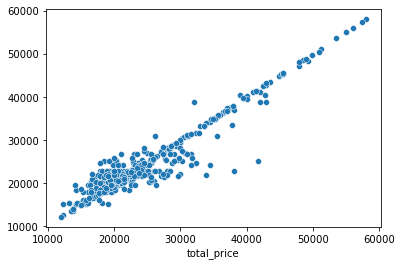

In [10]:
sns.scatterplot(x=y, y=y_pred)

Add predicted price and difference with real

In [11]:
df.loc[:, 'estimated_price'] = y_pred
df.loc[:, 'estimated_minus_real'] = df['estimated_price'] - df['total_price']
df.loc[:, 'pct_estimated_minus_real'] = df['estimated_minus_real'] / df['total_price']

Find rentals with highest difference between predicted price and real price, assuming these are undervalued

In [12]:
(df.sort_values('pct_estimated_minus_real', ascending=False)
   .loc[:, ['title', 'price', 'expenses', 'total_surface', 'balcony_and_terrace', 'estimated_price']]
   .head(15))

,title,price,expenses,total_surface,balcony_and_terrace,estimated_price
420,"Departamento en Alquiler, Nueva Cordoba, Mono ...",12000.0,2100.0,35.0,none,19559.820312
349,Departamento en Alquiler de 1 Dormitorio en Nu...,15000.0,2857.0,46.0,balcony,24588.085938
51,Departamento en Alquiler - 1 Dormitorio - Zona...,16000.0,2500.0,45.0,balcony,25211.779297
306,Alquila: Dpto 1 Drmitorio con Balcon / Nueva C...,14000.0,2666.0,50.0,balcony,22051.390625
450,Departamento en Alquiler de 1 Dormitorio S - B...,14500.0,4700.0,45.0,balcony,25211.779297
471,Departamento en Alquiler Obispo Salguero 400,14500.0,5400.0,55.0,balcony,25887.771484
232,Dpto Monoamb. Alquiler Nva Cordoba Chacabuco 3...,9500.0,4700.0,45.0,none,18466.951172
242,Alquilo 1 Dorm Nva Cba con Balcón,15000.0,4500.0,45.0,balcony,25211.779297
292,Alquila: Dpto 1 Dormitorio con 2 Balcones / Nu...,15000.0,2857.0,45.0,balcony,22957.234375
416,Hermoso Dpto a m de Parque Las Tejas - B° Nuev...,16900.0,4100.0,70.0,none,26775.568359
